# Mental Health in the Tech Industry

Requirements:<br>
* Perform exploratory data analysis. This should include creating statistical summaries and charts, testing for anomalies, checking for correlations and other relations between variables, and other EDA elements.
* Provide clear explanations in your notebook. Your explanations should inform the reader what you are trying to achieve, what results did you get, and what these results mean.
* Provide suggestions about how your analysis can be improved.

- This data is from Open Source Mental Illness (OSMI) using survey data from years 2014, 2016, 2017, 2018 and 2019. 
- the dataset can be dowloaded: https://www.kaggle.com/datasets/anth7310/mental-health-in-the-tech-industry
- Each survey measures and attitudes towards mental health and frequency of mental health disorders in the tech workplace.
- The survey is conducted online at the OSMI website and the OSMI team intends to use these data to help drive awareness and improve conditions for individuals with mental illness in the IT workplace. 
- It should be noted that as this is an online survey, it may be prone to voluntary response bias and may cause over representation of data. 
- The sample of respondents was not obtained through any random sampling approach. Furthermore, as this is an observational study with potential sampling biases present, causality can not be inferred.
- The results of the survey may not be generalizable to the entire population of Tech/IT workers due to the lack of random sampling. Keeping the above limitations in mind and being cautious with our interpretations, we can still use the data to gain some insight into the state of mental health in the tech workplace.


**To assess mental health support in the workplace, I chose the following features to analyze:**
- the open discussion in the workplace about mental health, and anonymity,
- the impact of the gender distribution of employees,
- Does size of the company relate to an employer formally discussing mental health.
- What would be the suggestions for companies to improve the mental environment.

In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [332]:
from collections import Counter
import folium
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sqlite3 as sql

sns.set_style("whitegrid")
print("Setup complete")

Setup complete


<IPython.core.display.Javascript object>

## Data Exploration

* Read sqlite query results into a pandas DataFrame:

In [3]:
con = sql.connect("mental_health.sqlite")

<IPython.core.display.Javascript object>

* Extract tables from dataset:

In [4]:
query = pd.read_sql_query(
    """SELECT name AS table_name, sql AS table_scheme
FROM sqlite_master
ORDER BY name""",
    con,
)
pd.set_option("display.max_colwidth", None)
query

,table_name,table_scheme
0,Answer,"CREATE TABLE ""Answer"" (\n\t""AnswerText"" VARCHAR(10000) NULL,\n\t""SurveyID"" INTEGER NULL,\n\t""UserID"" INTEGER NULL,\n\t""QuestionID"" INTEGER NULL\n)"
1,Question,"CREATE TABLE ""Question"" (\n\t""questiontext"" VARCHAR(1000) NULL,\n\t""questionid"" INTEGER NULL\n)"
2,Survey,"CREATE TABLE ""Survey"" (\n\t""SurveyID"" INTEGER NOT NULL,\n\t""Description"" VARCHAR(255) NULL,\n\tPRIMARY KEY (""SurveyID"")\n)"


<IPython.core.display.Javascript object>

* For convenience only: extracting all questions from dataset:

In [250]:
query = pd.read_sql_query(
    """SELECT *
       FROM question""",
    con,
)
pd.set_option("display.max_rows", None)
query.head()

,questiontext,questionid
0,What is your age?,1
1,What is your gender?,2
2,What country do you live in?,3
3,"If you live in the United States, which state or territory do you live in?",4
4,Are you self-employed?,5


<IPython.core.display.Javascript object>

* Extracting year of surveys, total number of questions asked and total number of respondents for every year of surveillance:

In [6]:
query_respondents = pd.read_sql_query(
    """
SELECT s.surveyid AS year, q.questionid AS questions_asked_total, COUNT(DISTINCT a.userid) AS total_respondents
FROM answer AS a
JOIN question AS q
ON a.questionid = q.questionid
JOIN survey AS s
ON a.surveyid = s.surveyid
GROUP BY year
ORDER BY year, MAX(questions_asked_total)""",
    con,
)
query_respondents

,year,questions_asked_total,total_respondents
0,2014,103,1260
1,2016,118,1433
2,2017,89,756
3,2018,89,417
4,2019,89,352


<IPython.core.display.Javascript object>

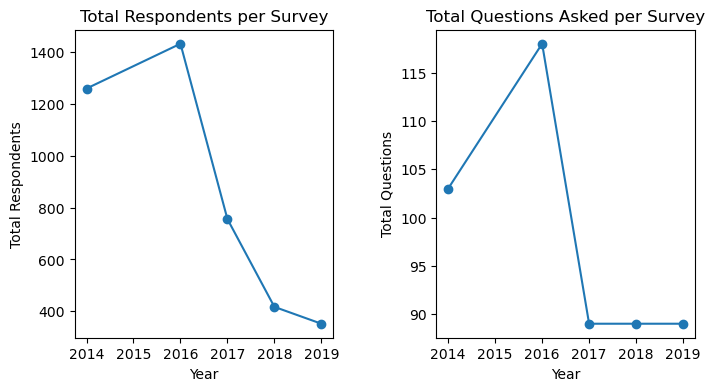

<IPython.core.display.Javascript object>

In [8]:
plt.figure(figsize=(8, 4))


plt.subplot(1, 2, 1)
plt.plot(
    query_respondents["year"], query_respondents["total_respondents"], "-o"
)  
plt.xlabel("Year")
plt.ylabel("Total Respondents")
plt.title("Total Respondents per Survey")


plt.subplot(1, 2, 2)
plt.plot(
    query_respondents["year"], query_respondents["questions_asked_total"], "-o"
)
plt.xlabel("Year")
plt.ylabel("Total Questions")
plt.title("Total Questions Asked per Survey")
plt.subplots_adjust(wspace=0.4, hspace=0.6)
plt.show()

* We summarise all responses received and all respondents:

In [8]:
query = pd.read_sql_query(
    """
SELECT COUNT(answertext) As all_replies, MAX(userid) AS total_respondents
FROM answer""",
    con,
)
query

,all_replies,total_respondents
0,236898,4218


<IPython.core.display.Javascript object>

* Checking if any values are NULL:

In [9]:
query = pd.read_sql_query(
    """
SELECT 
    (SELECT COUNT(*) FROM survey WHERE surveyid IS NULL OR description IS NULL) AS survey_null_count,
    (SELECT COUNT(*) FROM question WHERE questionid IS NULL OR questiontext IS NULL) AS question_null_count,
    (SELECT COUNT(*) FROM answer WHERE surveyid IS NULL OR questionid IS NULL OR userid IS NULL
                                       OR answertext IS NULL) AS answer_null_count""",
    con,
)
query

,survey_null_count,question_null_count,answer_null_count
0,0,0,0


<IPython.core.display.Javascript object>

* Distribution of respondents by country (combine 'United States' and 'United States of America'), and draw map:

In [10]:
query = """
UPDATE answer
SET answertext = 'United States of America'
WHERE answertext = 'United States'"""
cursor = con.cursor()
cursor.execute(query)
con.commit()

<IPython.core.display.Javascript object>

In [11]:
query = pd.read_sql_query(
    """SELECT a.answertext AS country, COUNT(*) AS respondents
FROM answer AS a
JOIN question AS q
ON a.questionid = q.questionid
WHERE q.questionid = 3
GROUP BY a.answertext
ORDER BY respondents DESC""",
    con,
)
df = pd.DataFrame(query)
df.head()

,country,respondents
0,United States of America,2604
1,United Kingdom,482
2,Canada,199
3,Germany,136
4,Netherlands,98


<IPython.core.display.Javascript object>

In [12]:
url = (
    "https://raw.githubusercontent.com/python-visualization/folium/master/examples/data"
)
geojson_data = f"{url}/world-countries.json"
country_map = folium.Map(location=[0, 0], zoom_start=1, width="80%", height="80%")
folium.Choropleth(
    geo_data=geojson_data,
    name="choropleth",
    data=df,
    columns=["country", "respondents"],
    key_on="feature.properties.name",
    fill_color="YlOrRd",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Respondents",
).add_to(country_map)
folium.LayerControl().add_to(country_map)
country_map

<IPython.core.display.Javascript object>

## Conclusions:

* The dataset consists of 3 tables (Answer, Question, Survey).
* The Surveys conducted in 2014-2019, but 2015 year was not surveyed.
* There are 118 questions in the question table in total, but not all questions where asked (2014 - 103 questions; 2016 - 118     questions, 2017-2019 were only 89 questions asked).
* The Answer table contains 236898 rows. There are a total of 4218 respondents in this dataset. The number of respondents varies: 2014 year - 1260 respondents, 2016 year-1433 respondents, 2017 year-756 respondents, 2018 year-417 respondents and 2019 year-352 respondents.
* There are no missing values in the dataset, but attention should be paid to incorrectly (erroneously?) reported data. As an example, the geographical distribution of respondents: 4 respondents indicated "-1" and "other" as their country.  This does not distort the overall question of which country had the highest number of respondents (USA - 2604 respondents).  Hence, this is a biased sample as no equivalent sample was selected. Please note that this is an online survey, so it may be subject to voluntary response bias. The sample of respondents was not randomly selected.

### Distribution of participant age:

* Assuming that working age could be between 15 and 80 years, let's check how many users get in this range. And we will see that not so many users will affect of analysis outcome:

In [13]:
query = pd.read_sql_query(
    """SELECT CAST(a.answertext AS int) AS age, COUNT(*) AS respondents_quantity
FROM answer AS a
JOIN question AS q
ON a.questionid = q.questionid
WHERE q.questionid = 1 AND (CAST(a.answertext AS int) < 15 OR CAST(a.answertext AS int) > 80)
GROUP BY age
ORDER BY age DESC""",
    con,
)
df = pd.DataFrame(query)
df

,age,respondents_quantity
0,329,1
1,323,1
2,99,1
3,11,1
4,8,1
5,5,1
6,3,1
7,0,1
8,-1,5
9,-29,1


<IPython.core.display.Javascript object>

* Assuming that the working population can be aged between 15 and 80 years, let's exclude participants belonging to this group:

In [14]:
query = pd.read_sql_query(
    """SELECT CAST(a.answertext AS int) AS age, COUNT(*) AS user_quantity
FROM answer AS a
JOIN question AS q
ON a.questionid = q.questionid
WHERE q.questionid = 1 AND (CAST(a.answertext AS int) > 15 AND CAST(a.answertext AS int) <= 80)
GROUP BY age
ORDER BY user_quantity DESC
""",
    con,
)
df = pd.DataFrame(query)
df.head()

,age,user_quantity
0,30,250
1,29,229
2,32,227
3,31,223
4,28,220


<IPython.core.display.Javascript object>

* We will check the percentage of all users in the decile age group:

In [15]:
total_users = df["user_quantity"].sum()
decile_groups = df.groupby(pd.cut(df["age"], bins=range(0, 91, 10))).sum()
decile_proportions = decile_groups["user_quantity"] * 100 / total_users
decile_proportions

age
(0, 10]      0.000000
(10, 20]     1.118249
(20, 30]    37.711159
(30, 40]    42.921723
(40, 50]    14.346895
(50, 60]     3.235784
(60, 70]     0.618606
(70, 80]     0.047585
(80, 90]     0.000000
Name: user_quantity, dtype: float64

<IPython.core.display.Javascript object>

* As histogram bellow shows, the biggest group of participants are between 20-40 years.

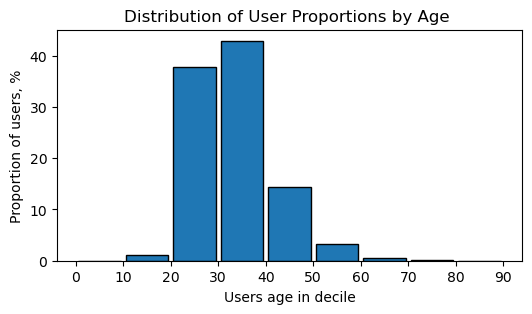

<IPython.core.display.Javascript object>

In [16]:
plt.figure(figsize=(6, 3))
distribution = plt.bar(
    [x + 5 for x in range(0, 90, 10)],
    decile_proportions.values,
    width=9,
    edgecolor=(0, 0, 0),
)
plt.xticks([10 * i for i in range(10)])
plt.xlabel("Users age in decile")
plt.ylabel("Proportion of users, %")
plt.title("Distribution of User Proportions by Age ")
plt.show()

### Conclusion:

* The Since the working group is assumed to be over 15 and under 80, we examined the age distribution of all respondents, which revealed that the majority of respondents are aged between 20 and 40.

### What is the number of participants by year and by choice of gender and their average age?

* As there were no strict parameters for the choice of gender, the most optimal options to describe the gender of the respondent were chosen: Female, Male and Other. Cases where respondents chose not to describe (-1 value, etc.) are classified as Other.

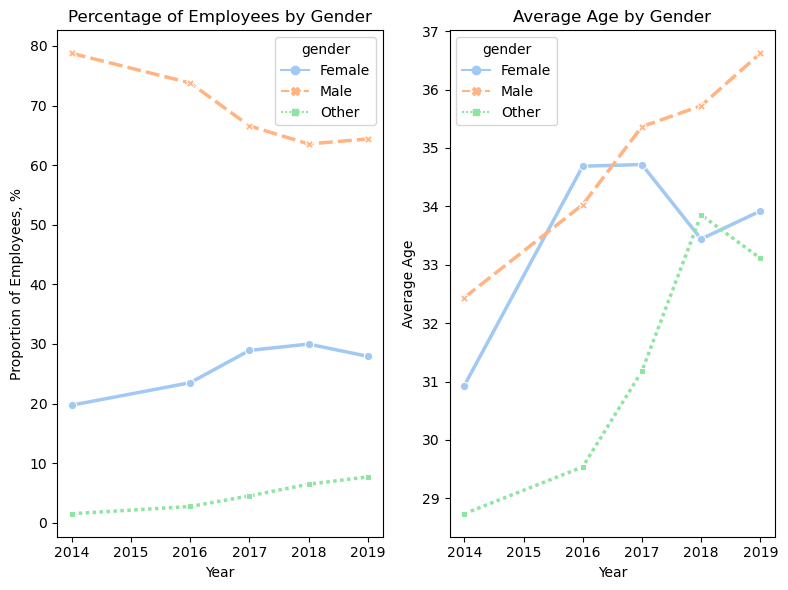

,year,gender,count,avg_age,"Proportion, %"
0,2014,Female,247,30.931174,19.73
1,2014,Male,986,32.437120,78.75
2,2014,Other,19,28.736842,1.52
3,2016,Female,336,34.687500,23.50
4,2016,Male,1055,34.028436,73.78
5,2016,Other,39,29.538462,2.73
6,2017,Female,218,34.715596,28.91
7,2017,Male,502,35.364542,66.58
8,2017,Other,34,31.176471,4.51
9,2018,Female,125,33.440000,29.98


<IPython.core.display.Javascript object>

In [63]:
df_age = pd.DataFrame(
    pd.read_sql_query(
        """
    SELECT a.surveyid AS year, a.userid, CAST(a.answertext AS int) AS age
    
    FROM answer AS a
    JOIN question AS q 
    ON a.questionid = q.questionid
    WHERE q.questionid = 1 AND age BETWEEN 15 AND 80                      --What is your age?
    """,
        con,
    )
)

df_gender = pd.DataFrame(
    pd.read_sql_query(
        """
    SELECT a.userid, a.answertext AS gender
    
    FROM answer AS a
    JOIN question AS q 
    ON a.questionid = q.questionid
    Where q.questionid = 2                                                   --What is your gender?
    GROUP BY a.userid
    """,
        con,
    )
)
df_merged_age_gender = pd.merge(df_age, df_gender, on="UserID", how="inner")
# df["age"] = df["age"].replace("[^0-9]+", "", regex=True).astype(int)
df_merged_age_gender["gender"] = df_merged_age_gender["gender"].replace(
    {"male": "Male", "female": "Female"}
)
grouped = (
    df_merged_age_gender.assign(
        gender=df_merged_age_gender["gender"].where(
            df_merged_age_gender["gender"].isin(["Male", "Female"]), "Other"
        )
    )
    .groupby(["year", "gender"])
    .agg(count=("gender", "count"), avg_age=("age", "mean"))
    .reset_index()
)
grouped["Proportion, %"] = grouped.groupby("year")["count"].transform(
    lambda x: round(x * 100 / x.sum(), 2)
)

plt.figure(figsize=(8, 6))
plt.subplot(1, 2, 1)
sns.lineplot(
    x="year",
    y="Proportion, %",
    hue="gender",
    data=grouped,
    palette="pastel",
    linewidth=2.5,
    style="gender",
    markers=True,
)
plt.xlabel("Year")
plt.ylabel("Proportion of Employees, %")
plt.title("Percentage of Employees by Gender")

plt.subplot(1, 2, 2)
sns.lineplot(
    x="year",
    y="avg_age",
    hue="gender",
    data=grouped,
    palette="pastel",
    linewidth=2.5,
    style="gender",
    markers=True,
)
plt.xlabel("Year")
plt.ylabel("Average Age")
plt.title("Average Age by Gender")

plt.tight_layout()
plt.show()
grouped

### Conclusion:
* In our selected working age group, the average age scale differs little by gender.
* We can draw a trend where the average age of working male participants increases every year while the average age of female participants decreases.
* It is also interesting to note that the initial surveys show a clear male dominance, but each year more and more female respondents join the survey.
* However, we can clearly see that the male gender-types are absolutely dominant in this survey.

### How many respondents have, or think they have, mental health issues?

* Checking the answers to whether the worker has ever been diagnosed a mental health disorder?

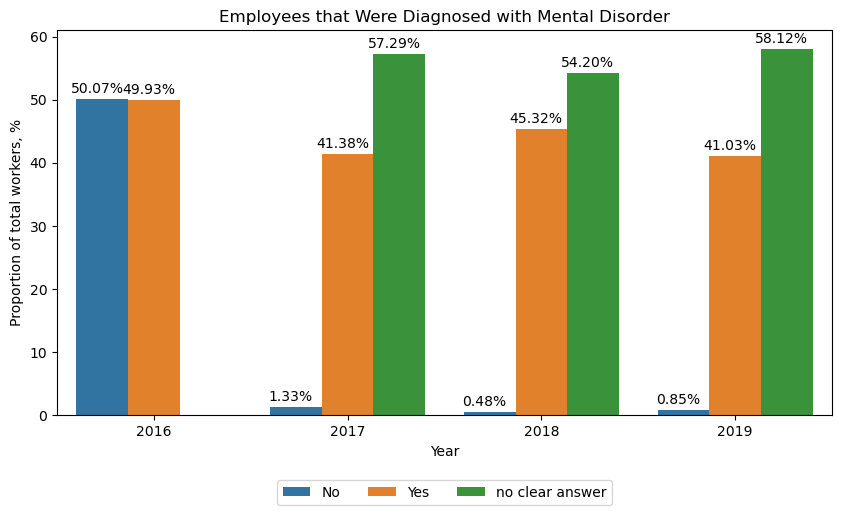

<IPython.core.display.Javascript object>

In [73]:
df1 = pd.DataFrame(
    pd.read_sql_query(
        """
    SELECT a.userid, a. AnswerText AS reply
    FROM answer AS a
    JOIN question AS q 
    ON a.questionid = q.questionid
    WHERE q.questionid = 34                      --Have you ever been diagnosed with a mental health disorder?
    """,
        con,
    )
)
df1["reply"] = df1["reply"].replace({"-1": "no clear answer"})
df = pd.merge(df_age, df1, on="UserID", how="inner")
total_employees = (
    df_merged_age_gender.groupby(df_merged_age_gender.year)["UserID"]
    .count()
    .reset_index(name="total_working")
)
df = pd.merge(df, total_employees, on="year", how="left")
df = df.groupby(["year", "total_working", "reply"]).agg(count=("reply", "count"))
df = df.reset_index()
df["Proportion, %"] = round(df["count"] * 100 / df["total_working"], 2)

plt.figure(figsize=(10, 5))
ax = sns.barplot(x="year", y="Proportion, %", hue="reply", data=df)
for i in ax.patches:
    ax.annotate(
        f"{i.get_height():.2f}%",
        (i.get_x() + i.get_width() / 2.5, i.get_height()),
        ha="center",
        va="center",
        xytext=(0, 10),
        textcoords="offset pixels",
    )
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=3)
plt.xlabel("Year")
plt.ylabel("Proportion of total workers, %")
plt.title("Employees that Were Diagnosed with Mental Disorder")
plt.show()

### Conclusion:
* As we can see, the question of whether you have ever been diagnosed with mental health disorder has been around since 2016, but this does not prevent from noticing some trends:<br>
* judging by the proportions of employees, only in 2016 were the answers more or less equally divided. Almost half of the respondents admitted to having a diagnosed psychological disorder;<br>
* however, already in the following years, we can see that an extremely small percentage of employees gave a negative answer. Judging by the increase in the percentage of workers who did not give a clear answer, it can be assumed that for some reason a clear answer is avoided.

### Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?

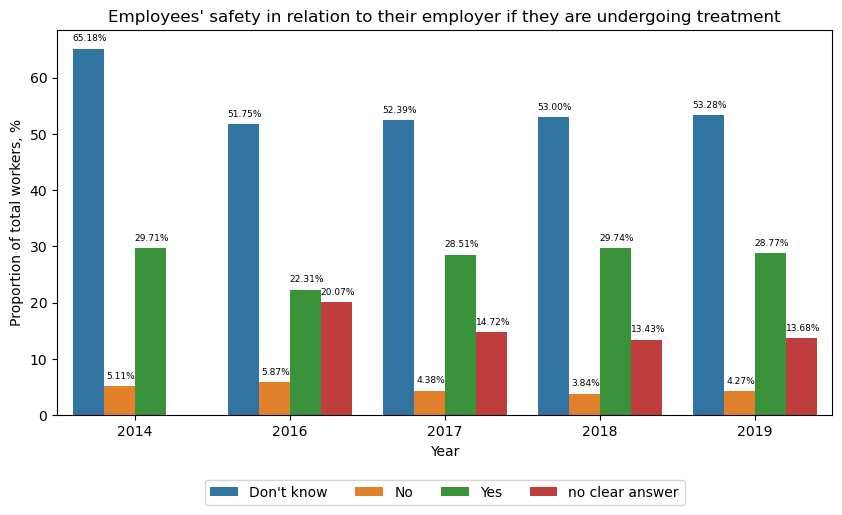

<IPython.core.display.Javascript object>

In [147]:
df1 = pd.DataFrame(
    pd.read_sql_query(
        """
    SELECT a.userid, a. AnswerText AS reply
    FROM answer AS a
    JOIN question AS q 
    ON a.questionid = q.questionid
    WHERE q.questionid = 11                     --Is your anonymity protected if you choose to take advantage of mental
                                                --health or substance abuse treatment resources provided by your employer?
    """,
        con,
    )
)
df1["reply"] = df1["reply"].replace(
    {"-1": "no clear answer", "I don't know": "Don't know"}
)
df = pd.merge(df_age, df1, on="UserID", how="inner")
total_employees = (
    df_merged_age_gender.groupby(df_merged_age_gender.year)["UserID"]
    .count()
    .reset_index(name="total_working")
)
df = pd.merge(df, total_employees, on="year", how="left")
df = df.groupby(["year", "total_working", "reply"]).agg(count=("reply", "count"))
df = df.reset_index()
df["Proportion, %"] = round(df["count"] * 100 / df["total_working"], 2)
plt.figure(figsize=(10, 5))
ax = sns.barplot(x="year", y="Proportion, %", hue="reply", data=df)
for i in ax.patches:
    ax.annotate(
        f"{i.get_height():.2f}%",
        (i.get_x() + i.get_width() / 1.8, i.get_height()),
        ha="center",
        va="center",
        fontsize=6.5,
        xytext=(0, 10),
        textcoords="offset pixels",
    )
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.xlabel("Year")
plt.ylabel("Proportion of total workers, %")
plt.title(
    "Employees' safety in relation to their employer if they are undergoing treatment"
)
plt.show()

### Conclusion:
* The data show that the majority of workers are unaware (or uninformed) that their identity will not be disclosed to their employer if they opt for medical treatment

### Does size of the company relate to an employer formally discussing mental health?

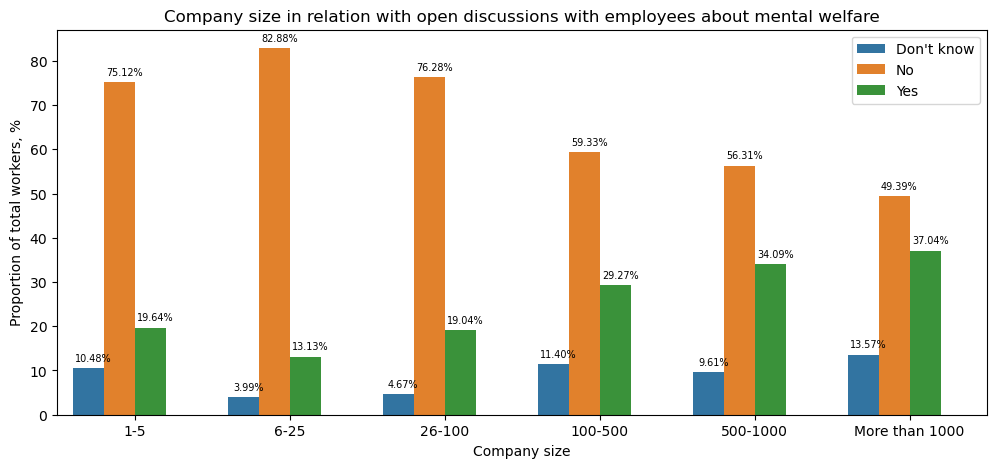

<IPython.core.display.Javascript object>

In [247]:
df1 = pd.DataFrame(
    pd.read_sql_query(
        """
    SELECT a.userid, a. AnswerText AS reply
    FROM answer AS a
    JOIN question AS q 
    ON a.questionid = q.questionid
    WHERE q.questionid = 15            --Has your employer ever formally discussed mental health 
                                       --(for example, as part of a wellness campaign or other official communication)?
    """,
        con,
    )
)
df2 = pd.DataFrame(
    pd.read_sql_query(
        """
    SELECT a.userid, a. AnswerText AS company_size
    
    FROM answer AS a
    JOIN question AS q 
    ON a.questionid = q.questionid
    WHERE q.questionid = 8            --How many employees does your company or organization have?
    """,
        con,
    )
)

df1["reply"] = df1["reply"].replace(
    {"-1": "no clear answer", "I don't know": "Don't know"}
)
df2["company_size"] = df2["company_size"].replace({"-1": "no clear answer"})
df = pd.merge(df_age, df1, on="UserID", how="inner")
total_employees = (
    df_merged_age_gender.groupby(df_merged_age_gender.year)["UserID"]
    .count()
    .reset_index(name="total_working")
)
df = pd.merge(df, total_employees, on="year", how="left")
df = pd.merge(df, df2, on="UserID", how="left")
df = (
    df.groupby(["year", "reply", "company_size"])
    .agg(reply_count=("reply", "count"))
    .reset_index()
)
df_total = df.groupby(["year", "company_size"])["reply_count"].sum().reset_index()

df_size = pd.merge(df, df_total, on=["year", "company_size"])
df_size["Proportion, %"] = round(
    df_size["reply_count_x"] * 100 / df_size["reply_count_y"], 2
)
plt.figure(figsize=(12, 5))
ax = sns.barplot(
    x="company_size",
    y="Proportion, %",
    hue="reply",
    data=df_size,
    order=["1-5", "6-25", "26-100", "100-500", "500-1000", "More than 1000"],
    errorbar=("ci", False),
)
for i in ax.patches:
    ax.annotate(
        f"{i.get_height():.2f}%",
        (i.get_x() + i.get_width() / 1.5, i.get_height()),
        ha="center",
        va="center",
        fontsize=7,
        xytext=(0, 10),
        textcoords="offset pixels",
    )
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=3)
plt.xlabel("Company size")
plt.ylabel("Proportion of total workers, %")
plt.title(
    "Company size in relation with open discussions with employees about mental welfare"
)
handles, labels = ax.get_legend_handles_labels()
new_handles = [handles[0], handles[1], handles[2]]
new_labels = [labels[0], labels[1], labels[2]]
ax.legend(new_handles, new_labels, loc="upper right")
plt.show()

### Conclusion:
- The percentage of negative responses is clearly visible for all companies taken as a whole, irrespective of their size;
- However, when comparing the visualisation of positive and negative responses, it should be noted that companies with more than 1 000 employees tend to care more about them. There are also companies with up to 1000 employees for which the psychological well-being of the employees is also important.
- A general observation would be that the higher the number of employees in a company, the more positive the employees' attitude towards the employer's efforts to communicate openly about the employees' mental condition. 

## With whom employees would like to discuss their mental state?

* I would like to compare the answers to two questions: does the employee want to discuss his/her mental state with a co-worker or with his/her manager (supervisor)

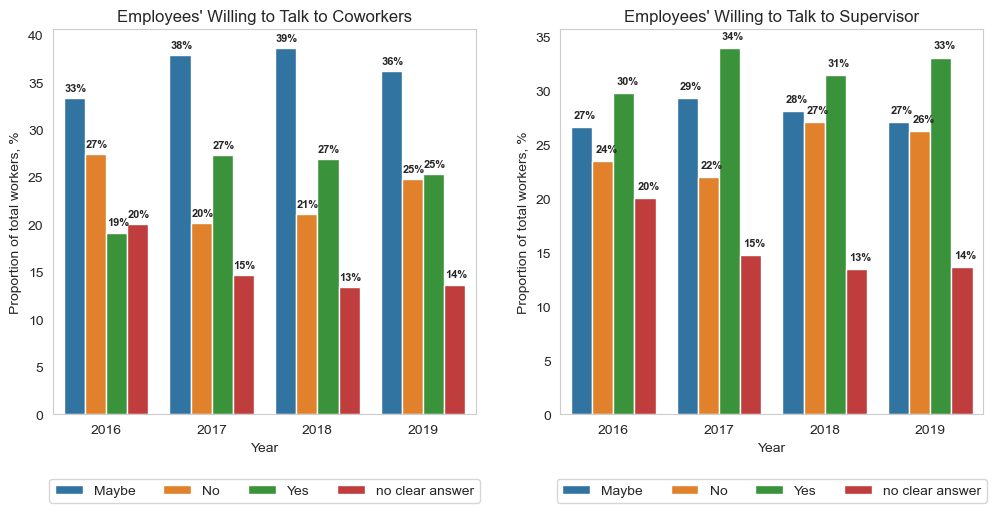

<IPython.core.display.Javascript object>

In [339]:
df1 = pd.DataFrame(
    pd.read_sql_query(
        """
    SELECT a.userid, a. AnswerText AS coworker_reply
    
    FROM answer AS a
    JOIN question AS q 
    ON a.questionid = q.questionid
    WHERE q.questionid = 18            --Would you feel comfortable discussing a mental health issue with your coworkers?
    """,
        con,
    )
)
df2 = pd.DataFrame(
    pd.read_sql_query(
        """
    SELECT a.userid, a. AnswerText AS supervisor_reply
    
    FROM answer AS a
    JOIN question AS q 
    ON a.questionid = q.questionid
    WHERE q.questionid = 19            --Would you feel comfortable discussing a mental health issue with your direct supervisor(s)?
    """,
        con,
    )
)
df1["coworker_reply"] = df1["coworker_reply"].replace({"-1": "no clear answer"})
df2["supervisor_reply"] = df2["supervisor_reply"].replace({"-1": "no clear answer"})
df = pd.merge(df1, df2, on="UserID", how="inner")
df = pd.merge(df, df_merged_age_gender, on="UserID", how="inner")
df = pd.merge(df, total_employees, on="year", how="left")

df_coworker = (
    df.groupby(["year", "total_working", "coworker_reply"])
    .agg(coworker_count=("coworker_reply", "count"))
    .reset_index()
)
df_coworker["Proportion, %_coworker"] = round(
    df_coworker["coworker_count"] * 100 / df_coworker["total_working"],
    2,
)
df_supervisor = (
    df.groupby(["year", "total_working", "supervisor_reply"])
    .agg(supervisor_count=("supervisor_reply", "count"))
    .reset_index()
)
df_supervisor["Proportion, %_supervisor"] = round(
    df_supervisor["supervisor_count"] * 100 / df_supervisor["total_working"],
    2,
)
plt.figure(figsize=(12, 5))
sns.set_style("whitegrid")
plt.subplot(1, 2, 1)
ax = sns.barplot(
    x="year",
    y="Proportion, %_coworker",
    hue="coworker_reply",
    data=df_coworker,
)
for i in ax.patches:
    ax.annotate(
        f"{i.get_height():.0f}%",
        (i.get_x() + i.get_width() / 1.8, i.get_height()),
        ha="center",
        va="center",
        font_properties={"weight": "bold", "size": 8},
        xytext=(0, 10),
        textcoords="offset pixels",
    )
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.xlabel("Year")
plt.ylabel("Proportion of total workers, %")
plt.title("Employees' Willing to Talk to Coworkers")
plt.grid(False)

plt.subplot(1, 2, 2)
ax = sns.barplot(
    x="year",
    y="Proportion, %_supervisor",
    hue="supervisor_reply",
    data=df_supervisor,
)
for i in ax.patches:
    ax.annotate(
        f"{i.get_height():.0f}%",
        (i.get_x() + i.get_width() / 1.5, i.get_height()),
        ha="center",
        va="center",
        font_properties={"weight": "bold", "size": 8},
        xytext=(0, 12),
        textcoords="offset pixels",
    )
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.xlabel("Year")
plt.ylabel("Proportion of total workers, %")
plt.title("Employees' Willing to Talk to Supervisor")
plt.grid(False)
plt.show()


### Conclusion:
* If we talk about communication with colleagues, there is clearly a sense of uncertainty among the staff. And in all the years of observation, the doubt about whether it is possible to talk about one's own psychological state remains.
* However, if we look at the plot showing the communication with the supervisor directly, there is a clear positive answer that the employee wishes to discuss his/her mental state directly with his/her manager. This shows that employees trust their leaders and recognise their authority.

## Conclusions:
- The total amount of information covered by the survey ranges from 2014 to 2019.
- It is an online survey with a sufficiently clear geographical dependency, so it cannot be classified as a random survey.
However, the nature of the questions available and the number of respondents, 4218, give a good overall picture.
- This work is aimed at employees of working age, whether they work for the company or are self-employed, we can see that the most popular age group is between 20 and 40 years old. 
- The majority of the respondents are male, but the average age for the three gender groups makes it possible to choose not the gender, but the choice of employees as a group.  
- The data show that only in 2016 the clear answers show an almost equal number of workers with and without a mental disorder diagnosis. However, in the following years, even during the anonymous survey, the respondents were not inclined to give a clear answer to this question. 
- This leads to the next question of whether the employee is granted anonymity if he chooses the treatment options offered by the employer. To which the overwhelming majority in all years replied that they are not guaranteed anonymity if the employer offers the solution, because in this case the employee is not sure how the employer will react to the mental disorder.
- Looking at the extent to which the size of the company affects the employer's concern for their employees through open discussions, we clearly notice that the general trend is negative, but looking at the positive responses, we can make general observation showinge that the higher the number of employees in a company, the more positive the employees' attitude towards the employer's efforts to communicate openly about the employees' mental condition. 
- How can the company improve its performance so that employees get the psychological help they need, if, as the data show, employees do not express a high level of confidence in the company's discretion. In this case, the survey shows that employees are simply reluctant to discuss or question this type of communication about their psychological issue with other co-workers. The survey shows that employees are willing to discuss it with their supervisors rather all team. This could show trust in the company's leaders. 
- The survey showed that it would be worthwhile for companies to concentrate on training their leaders and managers to recognize and provide the necessary support to their subordinates. Such a concentration would be more commercially viable than investing in generic discussions or initiatives which, as the results show, do not have the desired effect.

## Improvements:
- To improve the graphical presentation of information and visualisation of the work, further development of the Seaborn, Matplotlib libraries is needed;
- further study of Pandas, SQL is also needed to improve the quality of the code itself.